## Import library yang digunakan

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix

## Load dataset

In [4]:
data = 'heart.csv'
df   = pd.read_csv(data)

df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


## Preprocessing

### make feature and target data

In [5]:
X = df.drop(columns = ['target'])
y = df['target']

print(X.shape)
print(y.shape)

(1025, 13)
(1025,)


### split the dataset

In [6]:
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify = y)

print(x_train.shape)
print(x_test.shape)

(768, 13)
(257, 13)


## Make decision tree model using library

In [7]:
clf = tree.DecisionTreeClassifier(random_state = 0)
clf.fit(x_train, y_train)

y_train_pred = clf.predict(x_train)
y_test_pred  = clf.predict(x_test)

### visualize the model

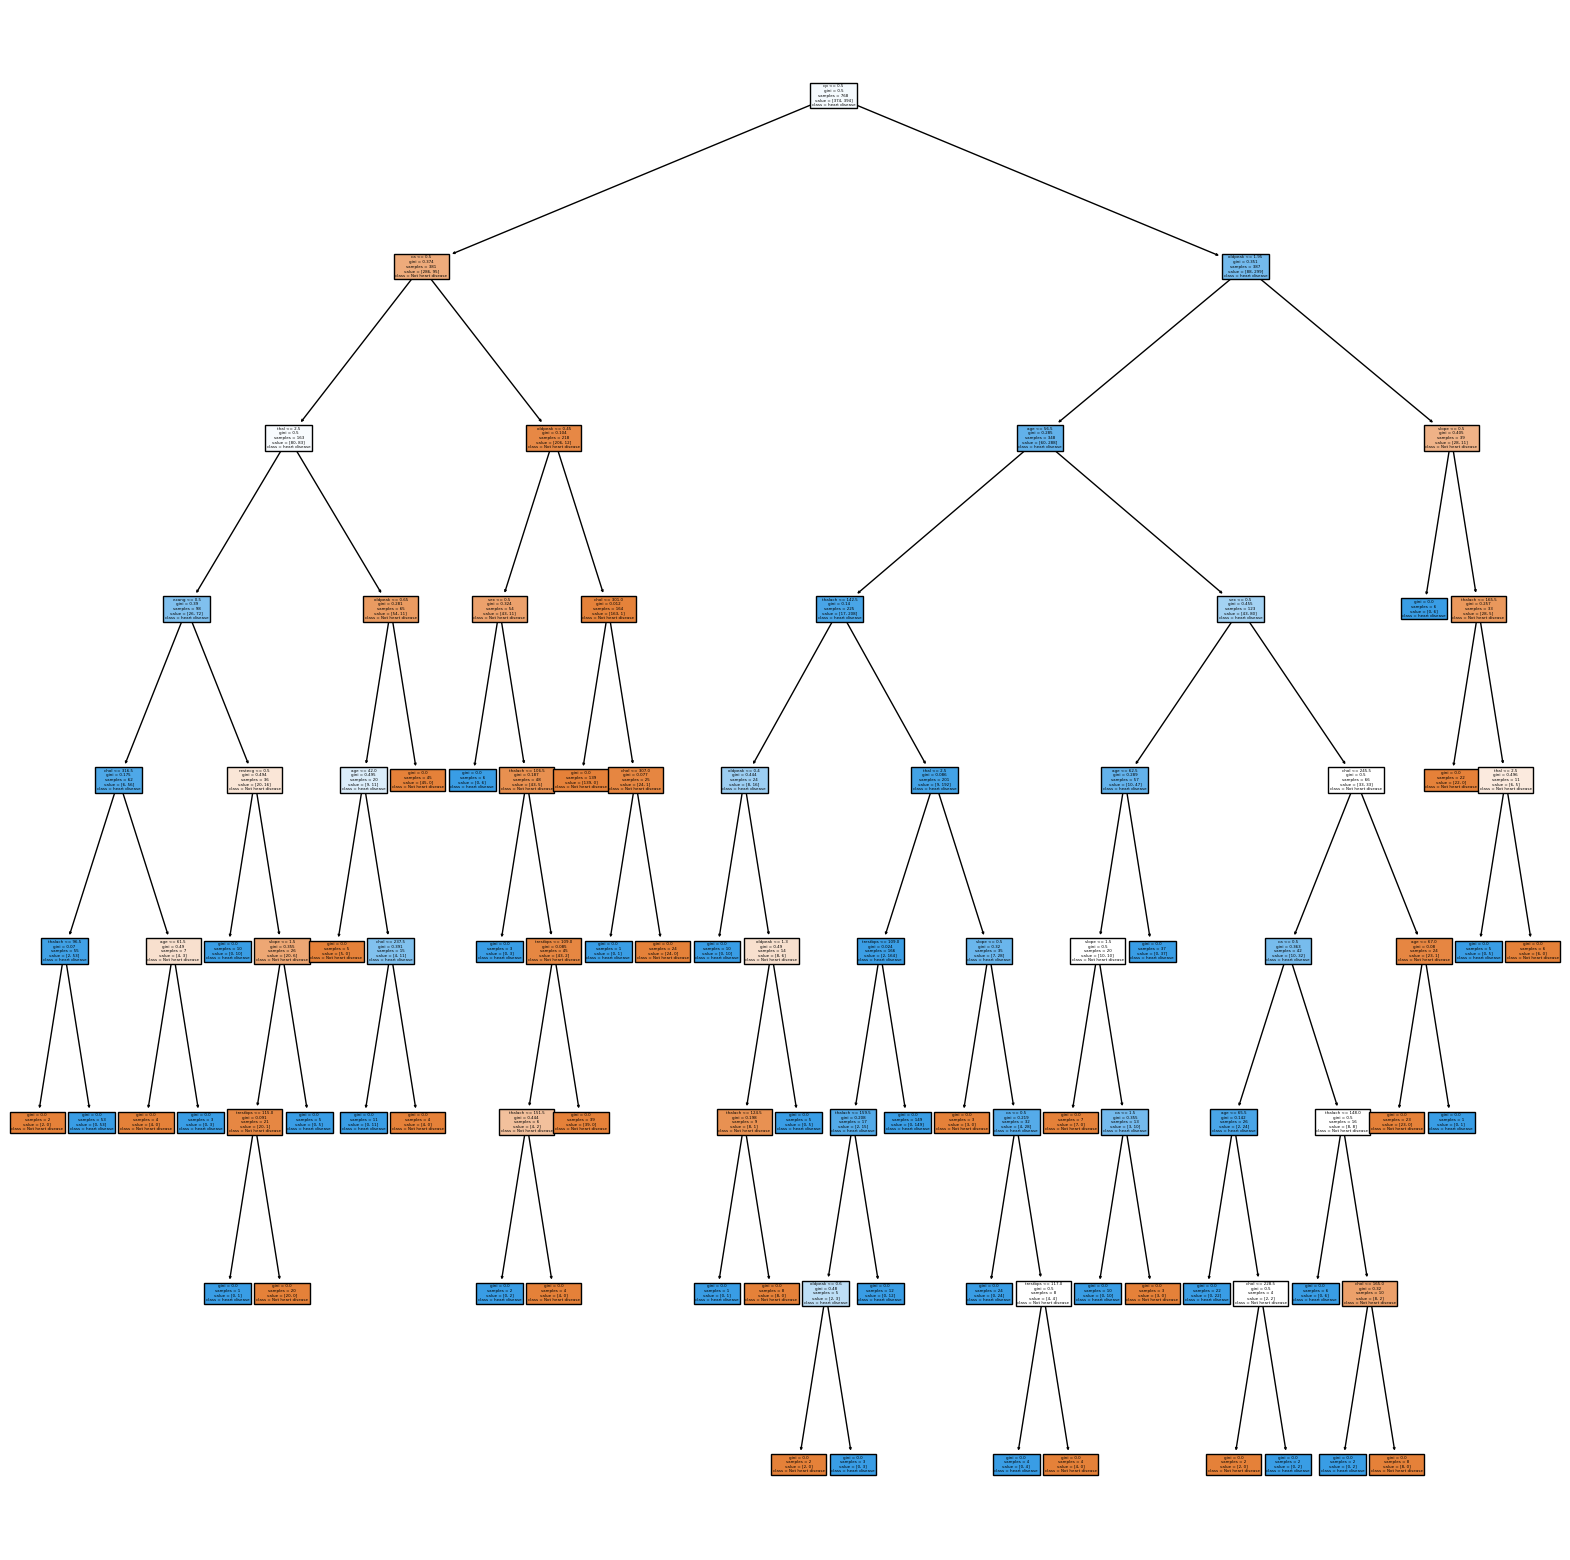

In [8]:
plt.figure(figsize = (20, 20))

features = df.columns
classes  = ['Not heart disease', 'heart disease']

tree.plot_tree(clf, feature_names = features, class_names = classes, filled = True)
plt.show()

### tampilkan confusion matrix

In [9]:
# fungsi consufion matrix
def plot_confusionmatrix(y_train_pred, y_train,dom):
    print(f'{dom} Confusion matrix')

    cf = confusion_matrix(y_train_pred, y_train)

    sns.heatmap(cf, annot = True, yticklabels = classes, xticklabels = classes, cmap = 'Blues', fmt = 'g')
    plt.tight_layout()
    plt.show()

Train score 1.0
Test score 0.9766536964980544
Train Confusion matrix


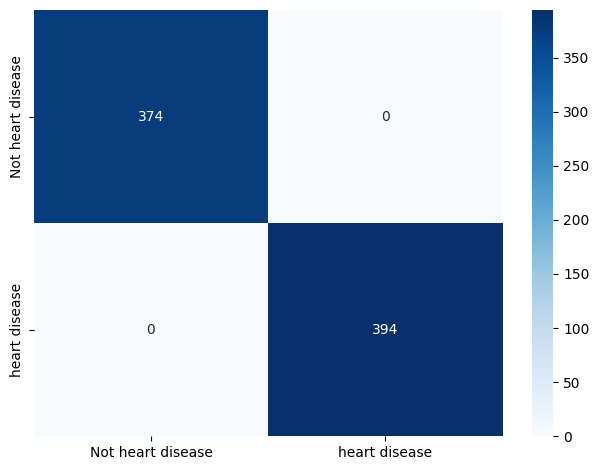

Test Confusion matrix


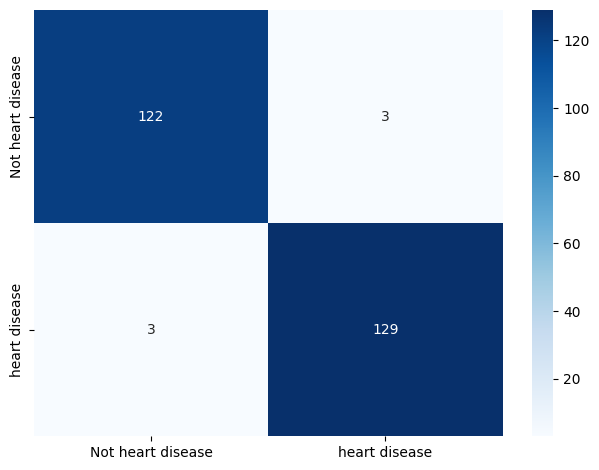

In [10]:
print(f'Train score {accuracy_score(y_train_pred, y_train)}')
print(f'Test score {accuracy_score(y_test_pred, y_test)}')

plot_confusionmatrix(y_train_pred, y_train, dom = 'Train')
plot_confusionmatrix(y_test_pred, y_test, dom = 'Test')

## Optimization Technique

### pre-pruning techniques

pre-pruning merupakan teknik untuk menghentikan decision tree di awal. Proses menghentikan decision tree ini dilakukan menggunakan beberapa batasan, seperti membatasi parameter (max_depth, min_samples, dll).

Cara efektif untuk melakukan pre-pruning adalah mencari grid parameter tersebut dan memilih nilai yang memberikan hasil optimal pada data test.


1. max_depth : maximum depth of decision tree
2. min_sample_split: The minimum number of samples required to split an internal node
3. min_samples_leaf: The minimum number of samples required to be at a leaf node.

Implementasi teknik pre-pruning

In [11]:
params = {'max_depth'       : [2, 4, 6, 8, 10, 12],
         'min_samples_split': [2, 3, 4],
         'min_samples_leaf' : [1, 2]}

clf = tree.DecisionTreeClassifier()
gcv = GridSearchCV(estimator = clf, param_grid = params)

gcv.fit(x_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3, 4]})

Train score 1.0
Test score 0.9883268482490273
Train Confusion matrix


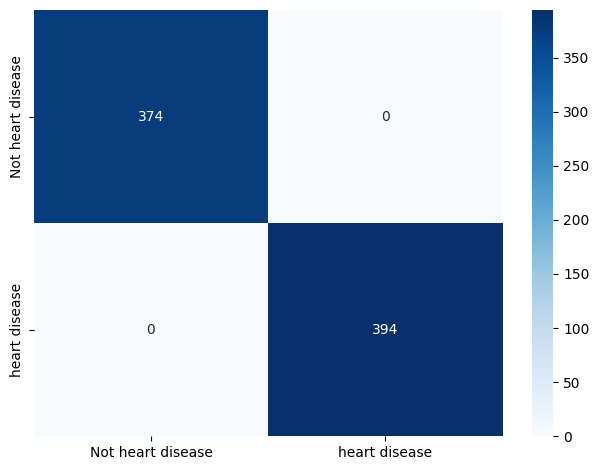

Test Confusion matrix


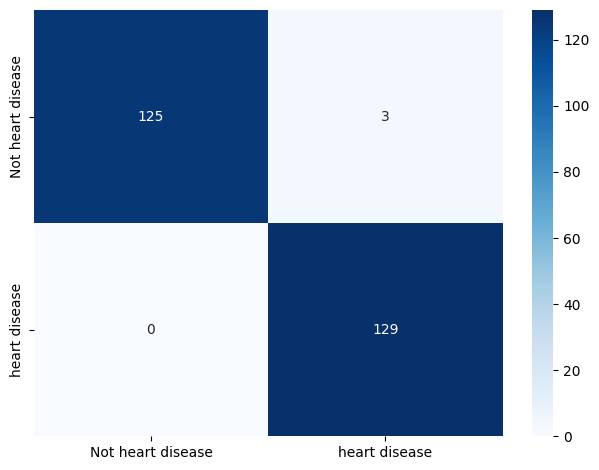

In [12]:
model = gcv.best_estimator_
model.fit(x_train, y_train)

y_train_pred = model.predict(x_train)
y_test_pred  = model.predict(x_test)

print(f'Train score {accuracy_score(y_train_pred, y_train)}')
print(f'Test score {accuracy_score(y_test_pred, y_test)}')

plot_confusionmatrix(y_train_pred, y_train, dom = 'Train')
plot_confusionmatrix(y_test_pred, y_test, dom = 'Test')

visualisasi

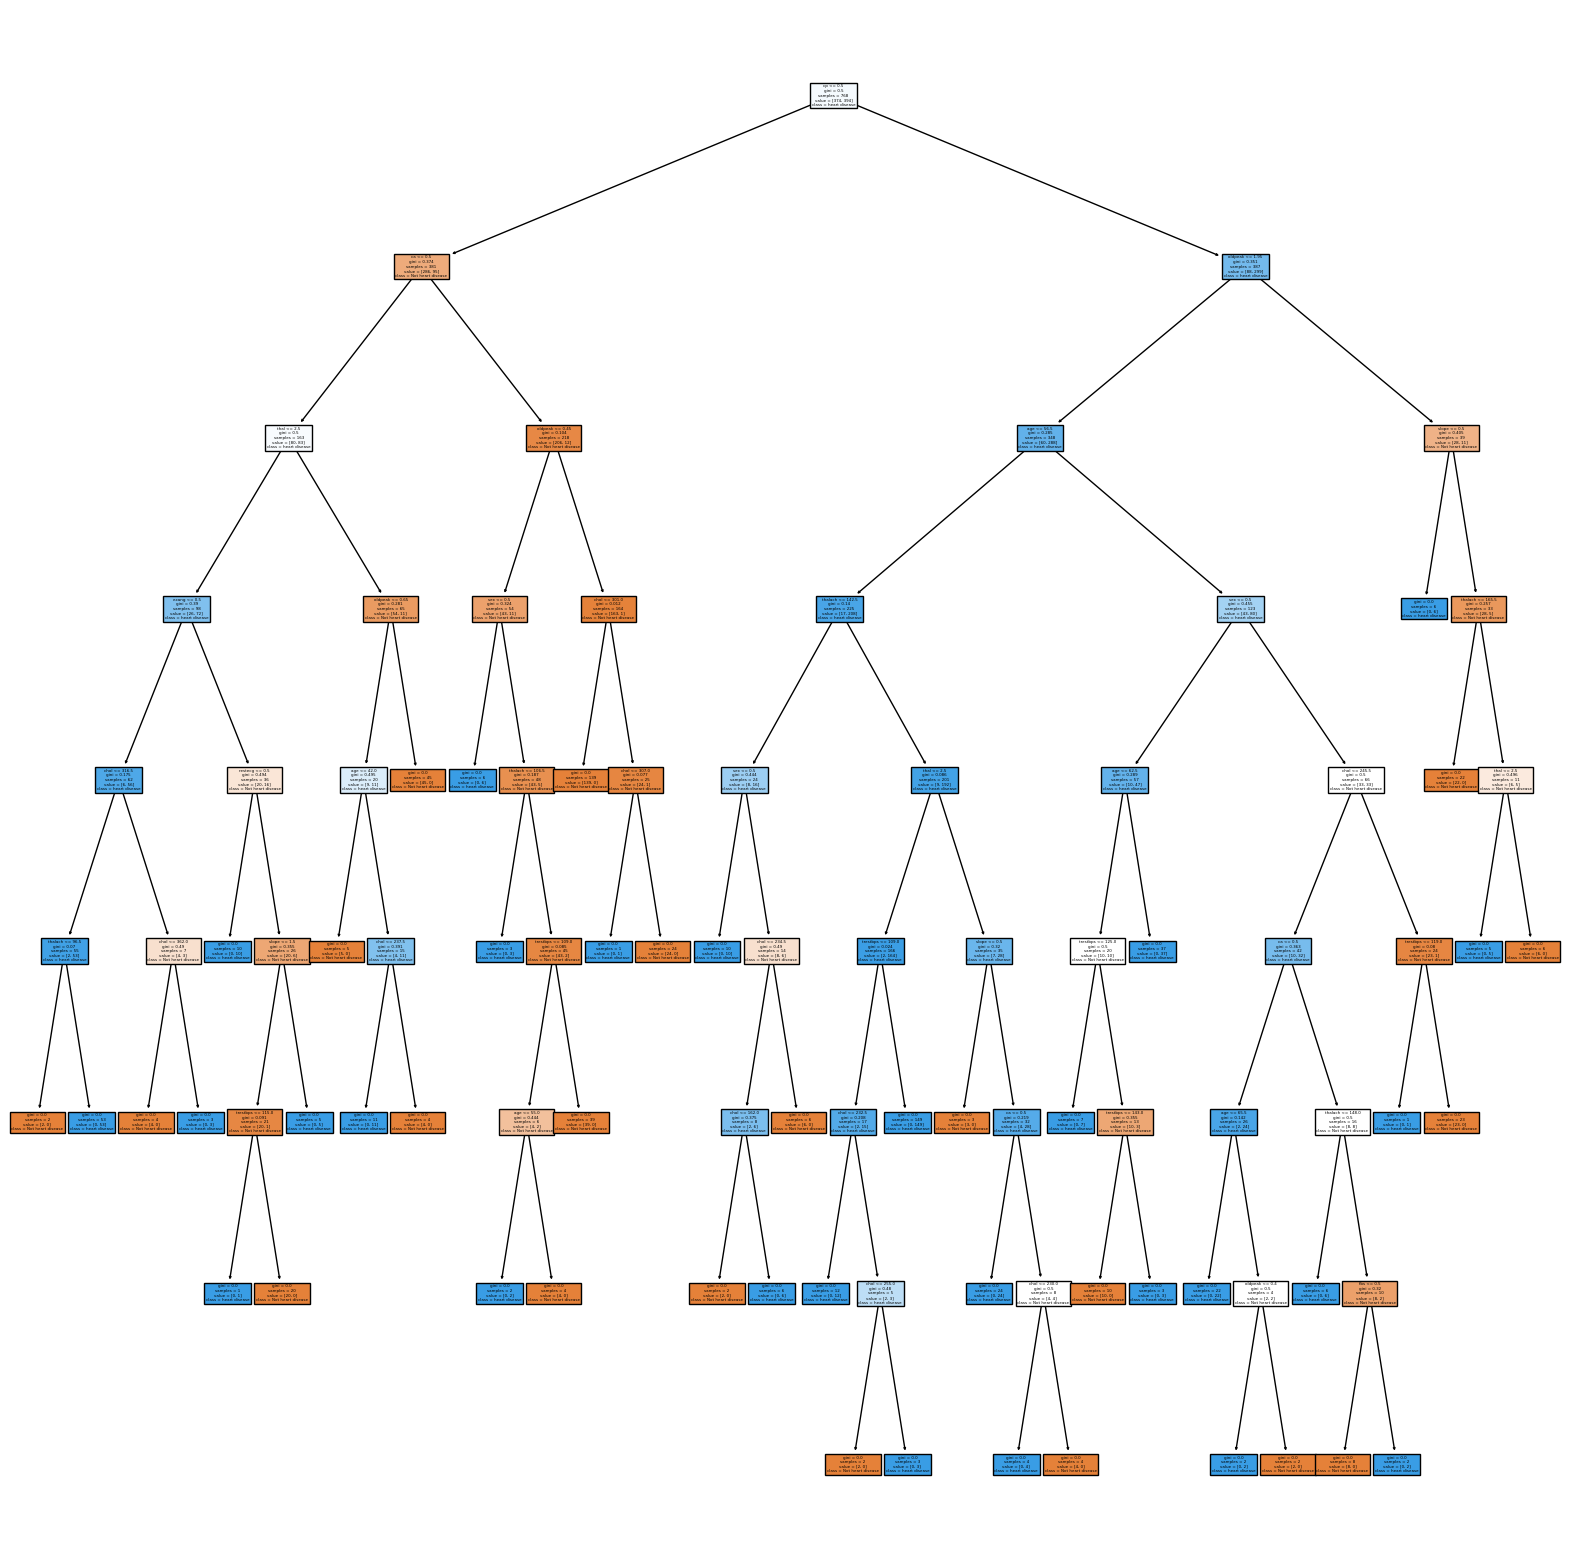

In [13]:
plt.figure(figsize = (20, 20))

features = df.columns
classes  = ['Not heart disease', 'heart disease']

tree.plot_tree(model, feature_names = features, class_names = classes, filled = True)
plt.show()

### post-pruning techniques (cost complexity pruning)

ovefitting sering terjadi pada decision tree, dimana untuk mengatasinya salah satu cara yang dapat digunakan ialah dengan memberi batasan pada tree kita. Namun, cara yang paling efisien adalah melalui penggunaan teknik post-pruning yang satunya adalah teknik cost complexity pruning. Teknik ini akan membentu meningkatkan akurasi dari model.

cost complexity pruning merupakan teknik untuk menemukan parameter yang paling sesuai untuk nilai alpha. Akan dicoba untuk mendapat nilai alpha dari tree dan kita evaluasi model hasilnya.

In [14]:
path = clf.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

print(ccp_alphas)

[0.         0.00129414 0.00171519 0.00240385 0.00248016 0.00248843
 0.00249566 0.00390625 0.00416667 0.00431062 0.00446429 0.00482431
 0.00487721 0.00543346 0.00552399 0.00600962 0.00644531 0.00668764
 0.00701122 0.00763852 0.00845212 0.00951826 0.00953907 0.01090745
 0.01112892 0.01248385 0.01451105 0.01555244 0.02717983 0.03254087
 0.05009555 0.13689529]


In [15]:
# For each alpha we will append our model to a list
clfs = []

for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state = 0, ccp_alpha = ccp_alpha)
    clf.fit(x_train, y_train)
    clfs.append(clf)

buang element terakhir dalam variabel clfs dan ccp_alphas, karena hanya memiliki 1 node.

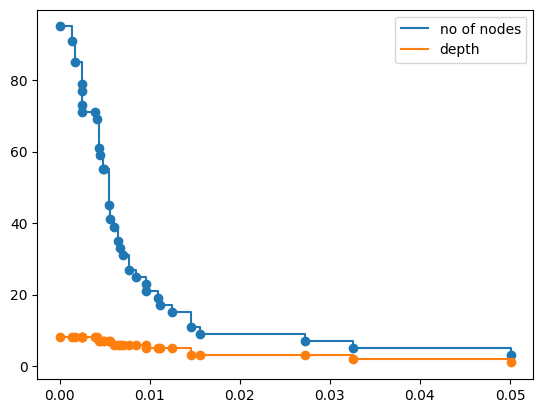

In [16]:
clfs        = clfs[:-1]
ccp_alphas  = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth       = [clf.tree_.max_depth for clf in clfs]

plt.scatter(ccp_alphas, node_counts)
plt.scatter(ccp_alphas, depth)
plt.plot(ccp_alphas, node_counts, label = 'no of nodes', drawstyle = "steps-post")
plt.plot(ccp_alphas, depth, label = 'depth', drawstyle = "steps-post")
plt.legend()
plt.show()

saat nilai alpha meningkat, jumlah nodes dan kedalaman berkurang.

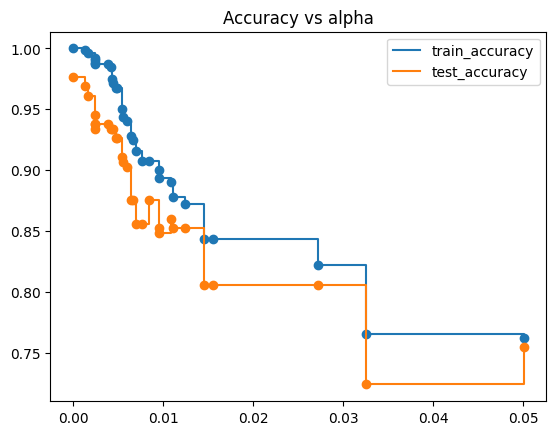

In [17]:
train_acc = []
test_acc  = []

for c in clfs:
    y_train_pred = c.predict(x_train)
    y_test_pred  = c.predict(x_test)
    train_acc.append(accuracy_score(y_train_pred, y_train))
    test_acc.append(accuracy_score(y_test_pred, y_test))

plt.scatter(ccp_alphas, train_acc)
plt.scatter(ccp_alphas, test_acc)
plt.plot(ccp_alphas, train_acc, label = 'train_accuracy', drawstyle = "steps-post")
plt.plot(ccp_alphas, test_acc, label = 'test_accuracy', drawstyle = "steps-post")
plt.legend()
plt.title('Accuracy vs alpha')
plt.show()

pilih alpha = 0.020

Train score 0.84375
Test score 0.8054474708171206
Train Confusion matrix


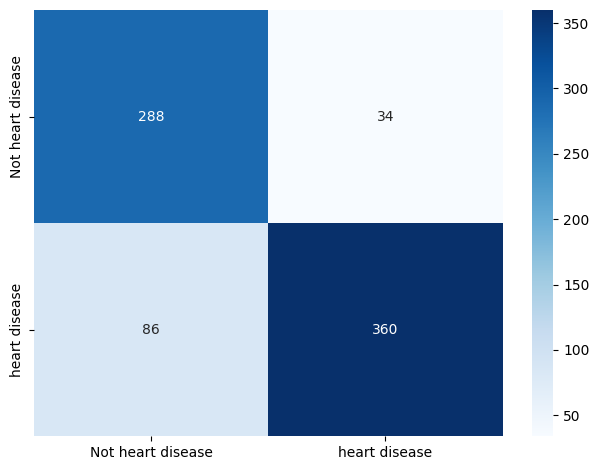

Test Confusion matrix


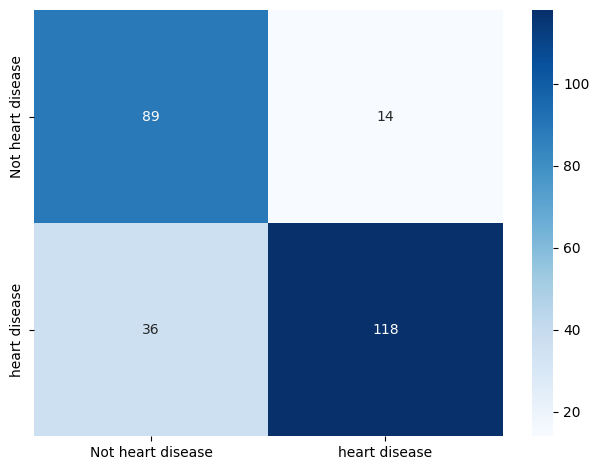

In [18]:
clf_ = tree.DecisionTreeClassifier(random_state = 0, ccp_alpha = 0.020)
clf_.fit(x_train, y_train)

y_train_pred = clf_.predict(x_train)
y_test_pred  = clf_.predict(x_test)

print(f'Train score {accuracy_score(y_train_pred, y_train)}')
print(f'Test score {accuracy_score(y_test_pred, y_test)}')
plot_confusionmatrix(y_train_pred, y_train, dom = 'Train')
plot_confusionmatrix(y_test_pred, y_test, dom = 'Test')

visualisasi

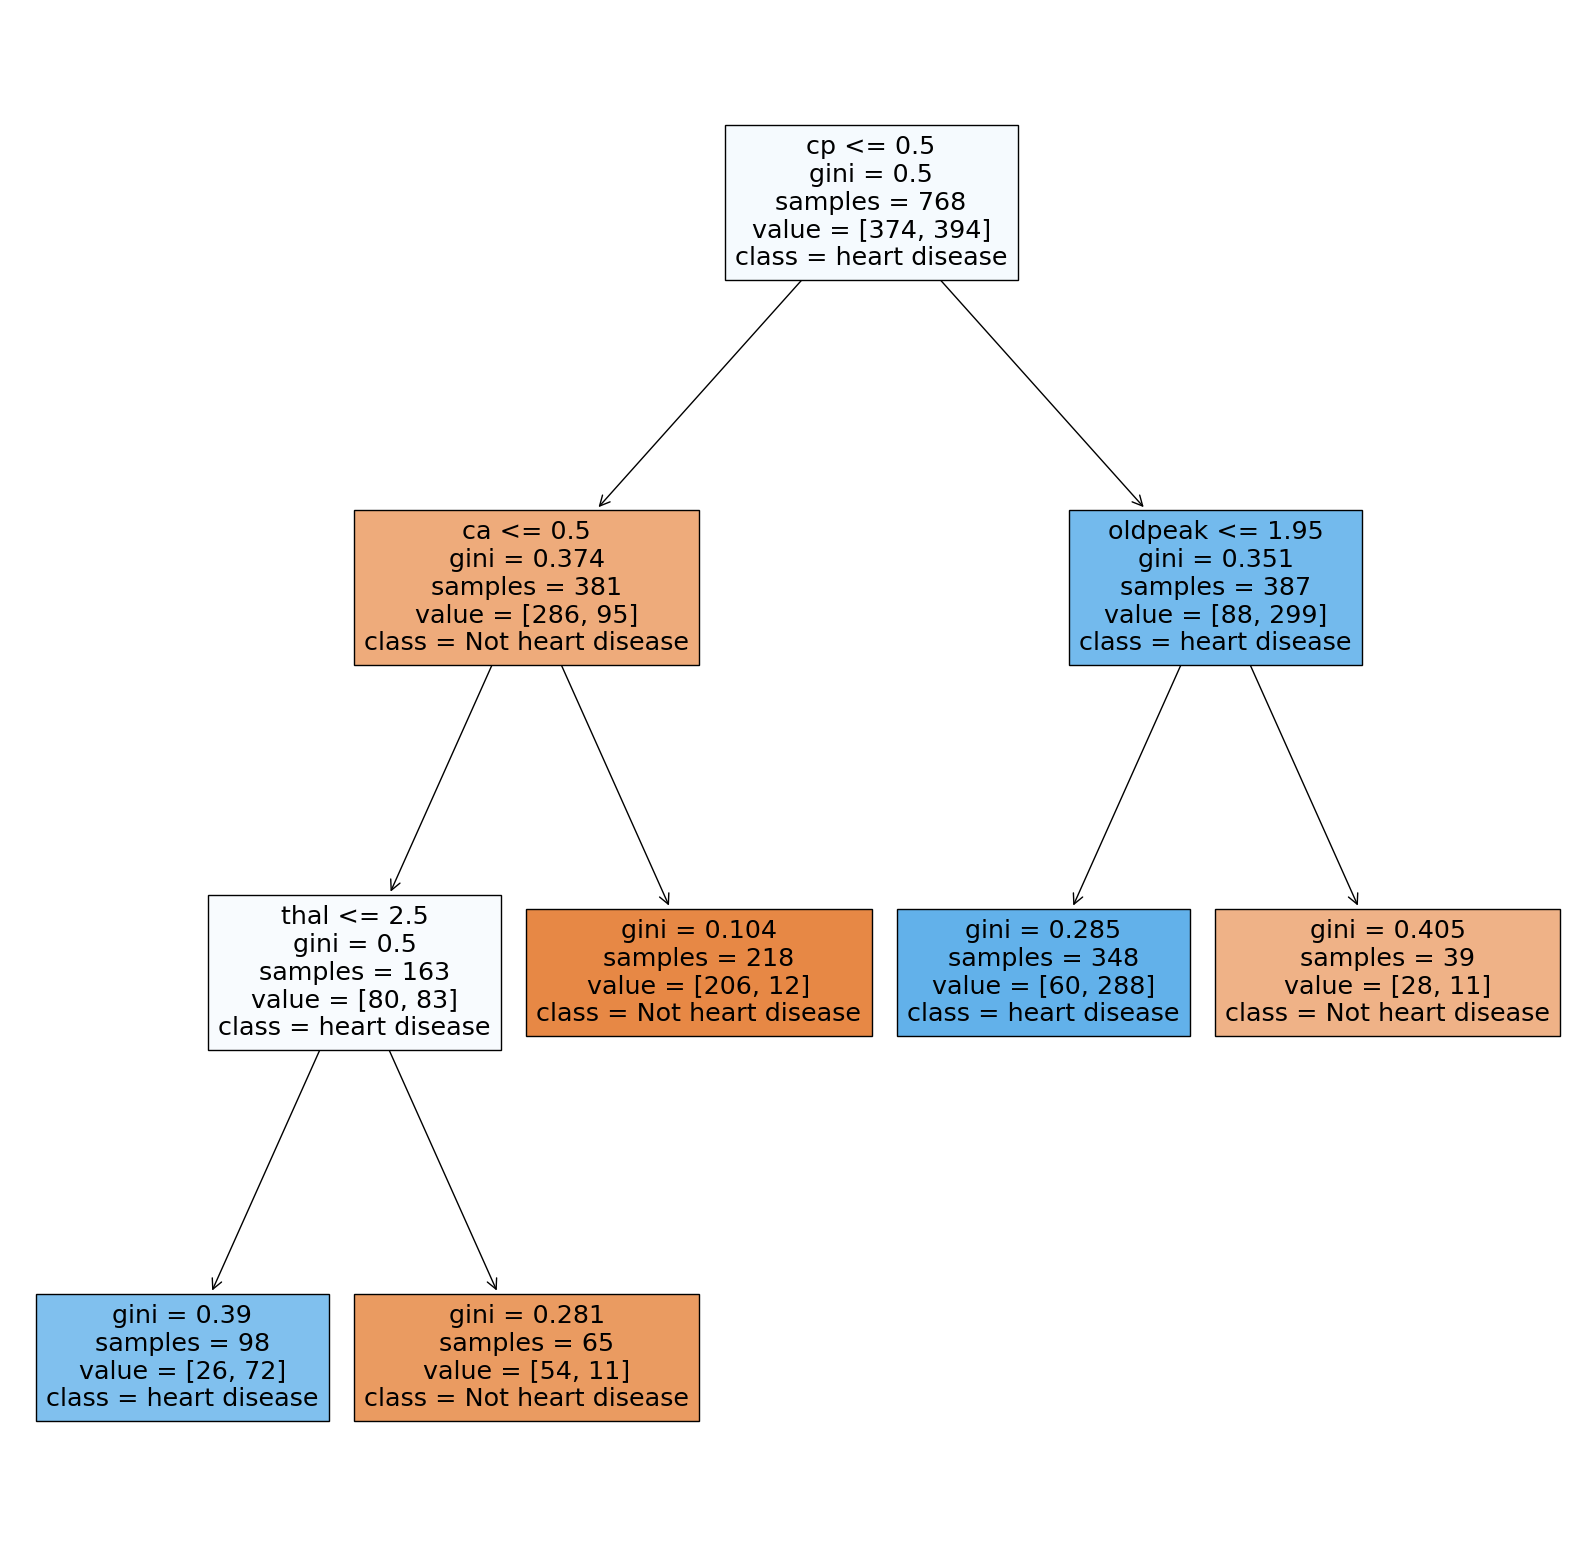

In [19]:
plt.figure(figsize = (20, 20))

features = df.columns
classes  = ['Not heart disease', 'heart disease']

tree.plot_tree(clf_,feature_names = features, class_names = classes, filled = True)
plt.show()